# PyTarsh Neural Network Library - Project Demo

## Team Members
- Omar Mohsen
- Youssf Mostafa
- Ahmed Abdallah

## 1. Introduction

### 1.1 Library Overview
PyTarsh is a neural network library built from scratch using only NumPy. This library was developed to understand the fundamental concepts of deep learning by implementing core components without relying on high-level frameworks like TensorFlow or PyTorch.

### 1.2 Key Features
Our library includes the following components:

**Layers:**
- Dense (Fully Connected) Layer

**Activation Functions:**
- ReLU (Rectified Linear Unit)
- Sigmoid
- Tanh (Hyperbolic Tangent)
- Softmax
- Linear (Identity)

**Loss Functions:**
- Mean Squared Error (MSE)

**Optimizers:**
- Stochastic Gradient Descent (SGD)

**Model Architecture:**
- Sequential Model (layers stacked in sequence)

### 1.3 Library Imports

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Import PyTarsh components
import sys
sys.path.append('..')  # Go up one directory
from PyTarsh import Sequential, Dense, SGD
from PyTarsh import mse_loss, mse_gradient
from PyTarsh import ReLU, Sigmoid, Tanh, Softmax

## 2. Gradient Checking (Unit Testing)

### 2.1 What is Gradient Checking?

Gradient checking is a technique used to verify that our backpropagation implementation is correct. It compares the analytical gradients computed by backpropagation with numerical gradients computed using finite differences.

**Formula for Numerical Gradient:**

$$\frac{\partial L}{\partial W} \approx \frac{L(W + \epsilon) - L(W - \epsilon)}{2\epsilon}$$

Where:
- $L$ is the loss function
- $W$ is a weight parameter
- $\epsilon$ is a small value (typically $10^{-7}$)

If our backpropagation is implemented correctly, the analytical gradient should be nearly identical to the numerical gradient (difference < $10^{-5}$).

### 2.2 Gradient Checking Implementation

In [5]:
def gradient_check(model, X, Y, epsilon=1e-7, loss_fn=mse_loss):
    """
    Perform gradient checking to verify backpropagation implementation.
    
    Compares analytical gradients (from backprop) with numerical gradients
    computed using finite differences: [L(W + ε) - L(W - ε)] / (2ε)
    
    Args:
        model: Sequential model with trained layers
        X: Input data, shape (batch_size, input_dim)
        Y: Target data, shape (batch_size, output_dim)
        epsilon: Small value for numerical gradient approximation (default: 1e-7)
        loss_fn: Loss function to use (default: mse_loss)
    
    Returns:
        Dictionary containing gradient differences for each layer
    """
    
    print("="*70)
    print("GRADIENT CHECKING")
    print("="*70)
    print(f"Epsilon: {epsilon}")
    print(f"Dataset size: {X.shape}")
    print()
    
    # Step 1: Forward pass and compute analytical gradients
    predictions = model.forward(X)
    loss = loss_fn(predictions, Y)
    loss_grad = mse_gradient(predictions, Y)
    model.backward(loss_grad)
    
    print(f"Initial Loss: {loss:.8f}")
    print()
    
    results = {}
    
    # Step 2: Check gradients for each layer
    for layer_idx, layer in enumerate(model.layers):
        if not hasattr(layer, 'weights'):
            continue
            
        print(f"Layer {layer_idx}: {layer.__class__.__name__}")
        print("-"*70)
        
        # Get analytical gradients
        analytical_weight_grad = layer.weights_gradient.copy()
        analytical_bias_grad = layer.biases_gradient.copy()
        
        # Initialize numerical gradients
        numerical_weight_grad = np.zeros_like(layer.weights)
        numerical_bias_grad = np.zeros_like(layer.biases)
        
        # Check WEIGHT gradients using numerical approximation
        print("Checking weight gradients...")
        original_weights = layer.weights.copy()
        
        # Sample a few random weights to check (checking all can be slow)
        num_samples = min(10, layer.weights.size)
        indices = np.random.choice(layer.weights.size, num_samples, replace=False)
        
        for idx in indices:
            i, j = np.unravel_index(idx, layer.weights.shape)
            
            # Compute L(W + ε)
            layer.weights[i, j] = original_weights[i, j] + epsilon
            predictions_plus = model.forward(X)
            loss_plus = loss_fn(predictions_plus, Y)
            
            # Compute L(W - ε)
            layer.weights[i, j] = original_weights[i, j] - epsilon
            predictions_minus = model.forward(X)
            loss_minus = loss_fn(predictions_minus, Y)
            
            # Numerical gradient: [L(W + ε) - L(W - ε)] / (2ε)
            numerical_weight_grad[i, j] = (loss_plus - loss_minus) / (2 * epsilon)
            
            # Restore original weight
            layer.weights[i, j] = original_weights[i, j]
        
        # Check BIAS gradients using numerical approximation
        print("Checking bias gradients...")
        original_biases = layer.biases.copy()
        
        for j in range(layer.biases.shape[1]):
            # Compute L(b + ε)
            layer.biases[0, j] = original_biases[0, j] + epsilon
            predictions_plus = model.forward(X)
            loss_plus = loss_fn(predictions_plus, Y)
            
            # Compute L(b - ε)
            layer.biases[0, j] = original_biases[0, j] - epsilon
            predictions_minus = model.forward(X)
            loss_minus = loss_fn(predictions_minus, Y)
            
            # Numerical gradient: [L(b + ε) - L(b - ε)] / (2ε)
            numerical_bias_grad[0, j] = (loss_plus - loss_minus) / (2 * epsilon)
            
            # Restore original bias
            layer.biases[0, j] = original_biases[0, j]
        
        # Compare analytical vs numerical gradients
        # Extract only the sampled weights for comparison
        sampled_analytical = np.array([analytical_weight_grad.flat[idx] for idx in indices])
        sampled_numerical = np.array([numerical_weight_grad.flat[idx] for idx in indices])
        
        weight_diff = np.abs(sampled_analytical - sampled_numerical)
        bias_diff = np.abs(analytical_bias_grad - numerical_bias_grad)
        
        # Compute relative error: |analytical - numerical| / max(|analytical|, |numerical|)
        weight_relative_error = weight_diff / (np.maximum(np.abs(sampled_analytical), np.abs(sampled_numerical)) + 1e-8)
        bias_relative_error = bias_diff / (np.maximum(np.abs(analytical_bias_grad), np.abs(numerical_bias_grad)) + 1e-8)
        
        # Store results
        results[f'layer_{layer_idx}'] = {
            'weight_max_diff': np.max(weight_diff),
            'weight_mean_diff': np.mean(weight_diff),
            'weight_relative_error': np.mean(weight_relative_error),
            'bias_max_diff': np.max(bias_diff),
            'bias_mean_diff': np.mean(bias_diff),
            'bias_relative_error': np.mean(bias_relative_error)
        }
        
        # Print results
        print(f"\nWeight Gradients (sampled {num_samples} values):")
        print(f"  Max absolute difference: {np.max(weight_diff):.2e}")
        print(f"  Mean absolute difference: {np.mean(weight_diff):.2e}")
        print(f"  Mean relative error: {np.mean(weight_relative_error):.2e}")
        
        print(f"\nBias Gradients:")
        print(f"  Max absolute difference: {np.max(bias_diff):.2e}")
        print(f"  Mean absolute difference: {np.mean(bias_diff):.2e}")
        print(f"  Mean relative error: {np.mean(bias_relative_error):.2e}")
        
        # Determine if gradients are correct
        weight_ok = np.max(weight_diff) < 1e-5
        bias_ok = np.max(bias_diff) < 1e-5
        
        if weight_ok and bias_ok:
            print(f"\n✓ PASSED: Gradients are correct!")
        else:
            print(f"\n✗ FAILED: Gradients may be incorrect!")
            if not weight_ok:
                print(f"  - Weight gradient difference too large")
            if not bias_ok:
                print(f"  - Bias gradient difference too large")
        
        print()
    
    print("="*70)
    print("GRADIENT CHECKING COMPLETE")
    print("="*70)
    
    return results

### 2.3 Running Gradient Check

In [13]:
def simple_gradient_check_example():
    """
    Simple example demonstrating gradient checking on XOR problem
    """
    print("\nGradient Checking Example: XOR Problem")
    print("="*70)
    
    # Create XOR dataset
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
    Y = np.array([[0], [1], [1], [0]], dtype=float)
    
    # Create a simple network
    model = Sequential()
    model.add(Dense(2, 4, activation="tanh"))
    model.add(Dense(4, 1, activation="sigmoid"))
    
    # Perform gradient checking
    results = gradient_check(model, X, Y, epsilon=1e-7)
    
    return results

### 2.4 Gradient Checking Results

In [16]:
results = simple_gradient_check_example()
    
print("\nInterpretation:")
print("-"*70)
print("If max absolute difference < 1e-5: ✓ Backpropagation is CORRECT")
print("If max absolute difference > 1e-5: ✗ Backpropagation may be INCORRECT")
print()
print("Typical good values:")
print("  - Absolute difference: < 1e-7 (excellent), < 1e-5 (good)")
print("  - Relative error: < 1e-5 (excellent), < 1e-3 (acceptable)")


Gradient Checking Example: XOR Problem
GRADIENT CHECKING
Epsilon: 1e-07
Dataset size: (4, 2)

Initial Loss: 0.27478910

Layer 0: Dense
----------------------------------------------------------------------
Checking weight gradients...
Checking bias gradients...

Weight Gradients (sampled 8 values):
  Max absolute difference: 3.23e-10
  Mean absolute difference: 1.56e-10
  Mean relative error: 7.59e-08

Bias Gradients:
  Max absolute difference: 2.51e-10
  Mean absolute difference: 1.35e-10
  Mean relative error: 1.16e-08

✓ PASSED: Gradients are correct!

Layer 1: Dense
----------------------------------------------------------------------
Checking weight gradients...
Checking bias gradients...

Weight Gradients (sampled 4 values):
  Max absolute difference: 5.14e-10
  Mean absolute difference: 2.95e-10
  Mean relative error: 1.76e-08

Bias Gradients:
  Max absolute difference: 2.70e-10
  Mean absolute difference: 2.70e-10
  Mean relative error: 4.09e-09

✓ PASSED: Gradients are corre

### 2.5 Interpretation


**Pass Criteria:**
- ✓ Max absolute difference < $10^{-5}$: Backpropagation is **CORRECT**
- ✗ Max absolute difference > $10^{-5}$: Backpropagation may be **INCORRECT**

**Typical Good Values:**
- Absolute difference: < $10^{-7}$ (excellent), < $10^{-5}$ (good)
- Relative error: < $10^{-5}$ (excellent), < $10^{-3}$ (acceptable)

## 3. XOR Problem

### 3.1 Problem Description

The XOR (Exclusive OR) problem is a classic non-linear classification problem that cannot be solved by a single perceptron. It requires a neural network with at least one hidden layer.

**XOR Truth Table:**

| Input 1 | Input 2 | Output |
|---------|---------|--------|
| 0       | 0       | 0      |
| 0       | 1       | 1      |
| 1       | 0       | 1      |
| 1       | 1       | 0      |

### 3.2 Dataset Preparation
```python

In [8]:
# Create XOR dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=float)
Y = np.array([[0], [1], [1], [0]], dtype=float)

### 3.3 Network Architecture


In [19]:
# Create the model
model = Sequential()

# Add the first hidden layer with 4 units
model.add(Dense(2,4,activation="tanh"))

# Add the second hidden layer with 2 units
model.add(Dense(4,2,activation="tanh"))

# Add the output layer with only 1 unit
model.add(Dense(2,1,activation="sigmoid"))

print("Network Architecture:")
model.summary()
print()

Network Architecture:
Network Architecture
Layer 1: Dense + tanh
  Shape: (2, 4)
  Parameters: 12
----------------------------------------------------------------------
Layer 2: Dense + tanh
  Shape: (4, 2)
  Parameters: 10
----------------------------------------------------------------------
Layer 3: Dense + sigmoid
  Shape: (2, 1)
  Parameters: 3
----------------------------------------------------------------------
Total Parameters: 25



### 3.4 Training the Network


In [21]:
optimizer = SGD(learning_rate=0.1)
optimizer.register_layers(model.layers)
history = model.fit(X, Y, epochs=10000, optimizer=optimizer, print_every=1000)

Epoch 1000/10000, Loss: 0.000253
Epoch 2000/10000, Loss: 0.000230
Epoch 3000/10000, Loss: 0.000211
Epoch 4000/10000, Loss: 0.000195
Epoch 5000/10000, Loss: 0.000181
Epoch 6000/10000, Loss: 0.000169
Epoch 7000/10000, Loss: 0.000159
Epoch 8000/10000, Loss: 0.000149
Epoch 9000/10000, Loss: 0.000141
Epoch 10000/10000, Loss: 0.000134
Training completed! Final Loss: 0.000134


### 3.5 Loss Visualization


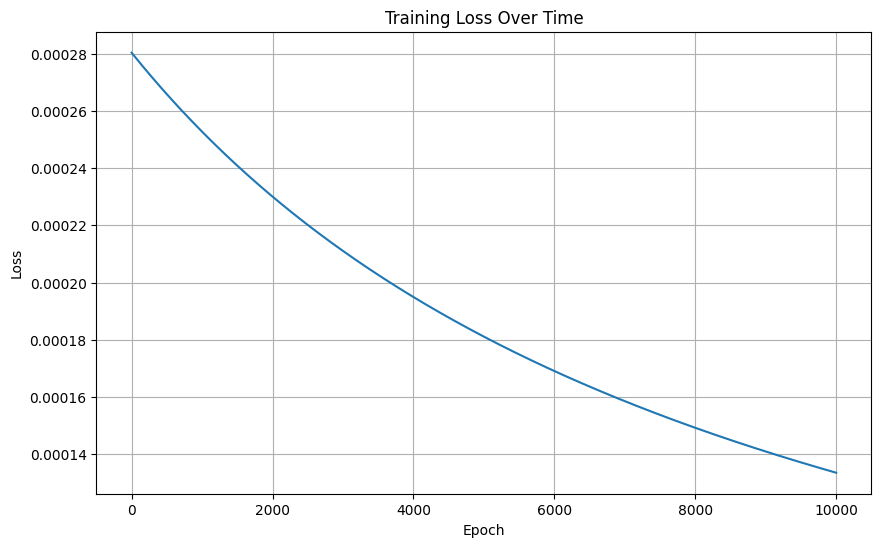

In [22]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

### 3.6 Model Predictions


In [11]:
predictions = model.predict(X)
classes = model.binary_classify(predictions)

### 3.7 Classification Results

In [12]:
print("\nTrue labels:")
print(Y.T)
print("\nPredicted probabilities:")
print(predictions.T)
print("\nPredicted classes:")
print(classes.T) 


True labels:
[[0. 1. 1. 0.]]

Predicted probabilities:
[[0.01421447 0.98383302 0.98319157 0.01808987]]

Predicted classes:
[[0. 1. 1. 0.]]
